In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import poppy

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.scoobi as scoobi
import scoobi.utils as utils

import scoobpsf.scoob_rmad as rmad

import lina
print(scoobi.__file__)
print(lina.__file__)

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

from magpyx.fdpr2 import console, tools

wavelength_c = 633e-9
npix = 1000


/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


/home/kianmilani/Projects/scoob-interface/scoobi/scoobi.py
/home/kianmilani/Projects/lina/lina/__init__.py


In [61]:
scoobi.home_block(client0)

In [ ]:
scoobi.move_block_out(client0)

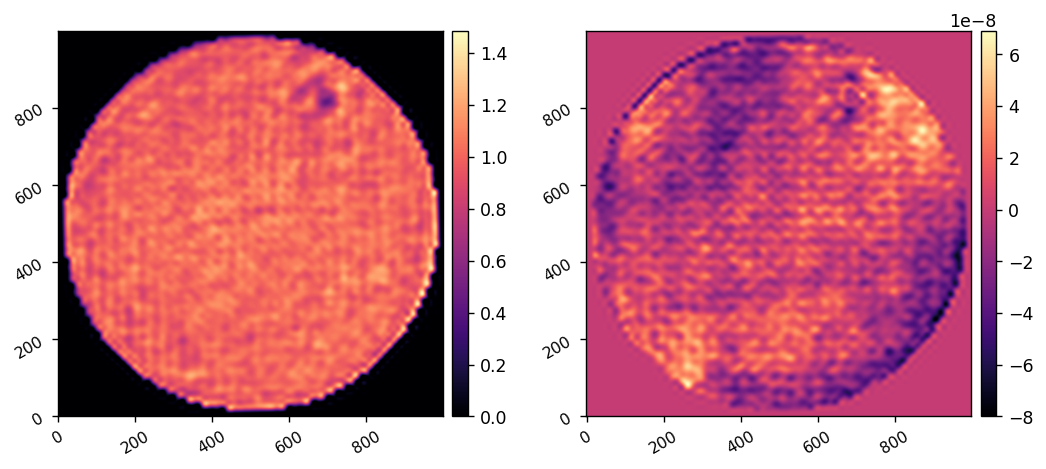

In [2]:
wfe_amp = xp.array(fits.getdata('data/pr_est_amp.fits'))
wfe_opd = xp.array(fits.getdata('data/pr_est_opd.fits'))
WFE = wfe_amp * xp.exp(1j* 2*np.pi/wavelength_c * wfe_opd)
imshow2(wfe_amp, wfe_opd)

In [3]:
reload(scoobi)
xc, yc = (4780, 3580)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [79]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp05')
I.npsf = 150

# Do the normalization

In [9]:
scoobi.move_psf(50, 0, client0)

In [10]:
reload(scoobi)
I.set_zwo_exp_time(0.000120, client0)

Set the ZWO exposure time to 1.20e-04s


In [11]:
reload(scoobi)
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [13]:
reload(scoobi)
I.set_fib_atten(30, client)

Set the fiber attenuation to 30.0


INFO:utils:Got semaphore index 0.


54336.78


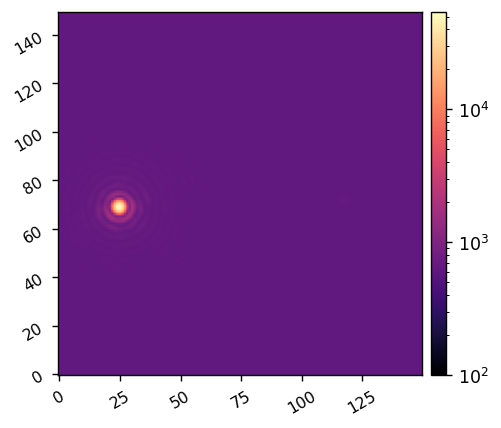

In [14]:
I.NSCICAM = 200
ref_psf = I.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)

In [80]:
# I.ref_psf_params = {
#     'ref_psf':copy.copy(ref_psf),
#     'Imax': copy.copy(xp.max(ref_psf)),
#     'texp': copy.copy(I.texp), 
#     'atten': copy.copy(I.atten),
#     'gain': copy.copy(I.gain),
# }
# utils.save_pickle(f'data/{today}_ref_psf_params.pkl', I.ref_psf_params)

I.ref_psf_params = utils.load_pickle(f'data/{today}_ref_psf_params.pkl')

In [40]:
scoobi.move_psf(-2, 0, client0)

In [42]:
scoobi.move_psf(0, -2, client0)

In [20]:
I.set_fib_atten(8, client)

Set the fiber attenuation to 8.0


In [43]:
I.set_zwo_exp_time(0.005, client0)

Set the ZWO exposure time to 5.00e-03s


In [44]:
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [45]:
reload(scoobi)
scoobi.move_block_in(client0)

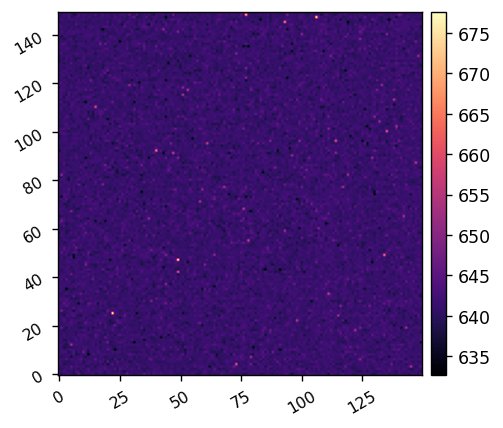

In [81]:
# I.NSCICAM = 200
# I.subtract_dark = False
# I.return_ni = False
# dark_frame = I.snap()
# utils.save_fits(f'data/{today}_camsci_dark_frame.fits', dark_frame, header={'EXPTIME':I.texp, 'GAIN':I.gain, 'ATTEN':I.atten})

dark_frame = utils.load_fits(f'data/{today}_camsci_dark_frame.fits')
I.df = copy.copy(dark_frame)
imshow1(dark_frame)

In [47]:
reload(scoobi)
scoobi.move_block_out(client0)

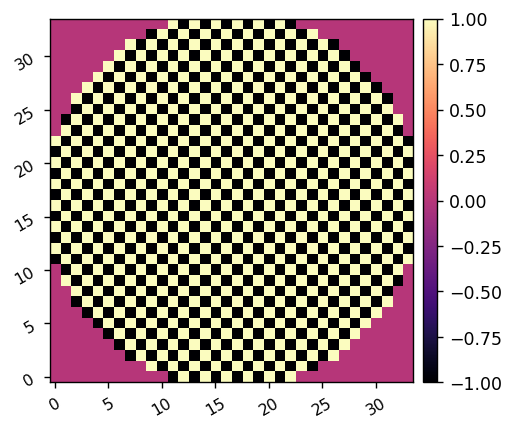

In [93]:
reload(scoobi.utils)
waffle_command = lina.utils.make_fourier_command(x_cpa=17, y_cpa=17) * xp.array(I.dm_mask)
imshow1(waffle_command)

Set the ZWO exposure time to 1.00e-03s


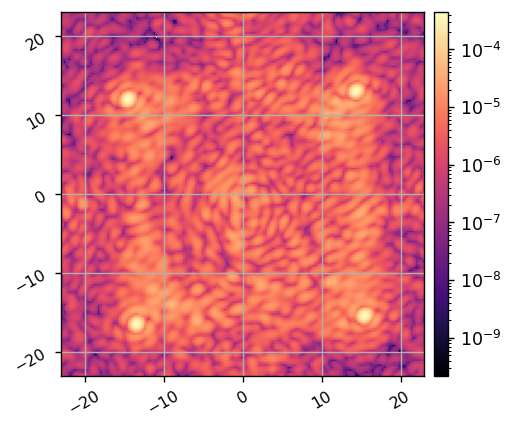

In [94]:
I.set_dm(15e-9 * waffle_command)
I.x_shift = 0
I.y_shift = 0

I.set_zwo_exp_time(0.001, client0)

I.NSCICAM = 100
I.subtract_dark = True
I.return_ni = True
waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=I.psf_pixelscale_lamD, grid=True)

Centroids:
 [[ 30.78038392  20.97560652]
 [ 27.08167893 113.53189637]
 [121.08514664 116.91361896]
 [124.63213104  24.42383044]
 [ 30.78038392  20.97560652]]


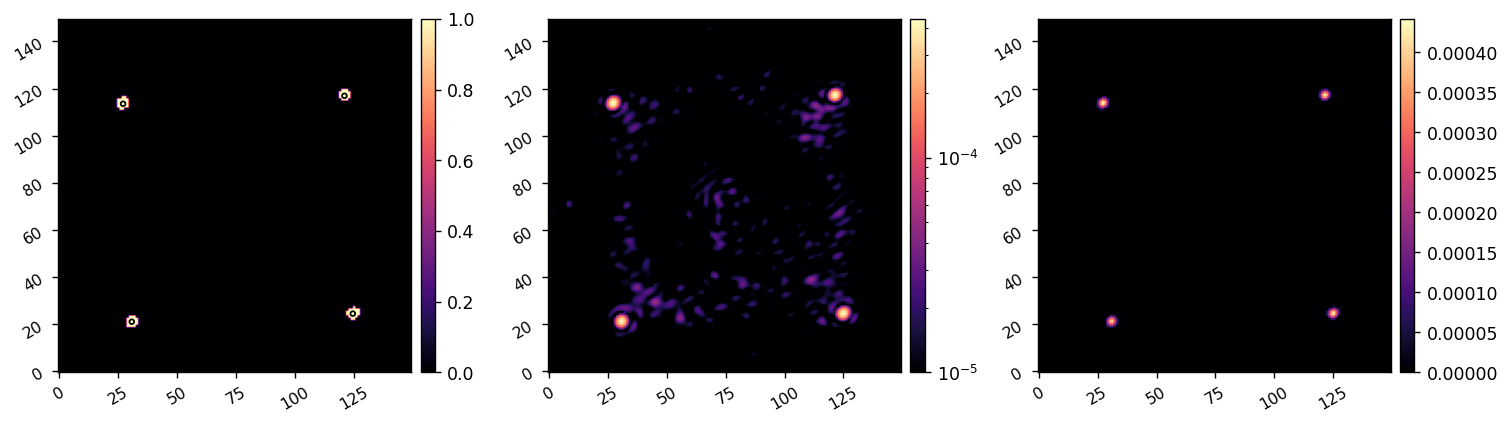

Angle:  87.83772524053967
Measured center in X:  75.91452268247536
Measured center in Y:  68.92523216356037
Required shift in X:  -1.0
Required shift in Y:  6.0


In [95]:
reload(scoobi.utils)

xshift,yshift,angle = scoobi.utils.measure_center_and_angle(waffle_im, I.psf_pixelscale_lamD, im_thresh=7e-5, r_thresh=16)

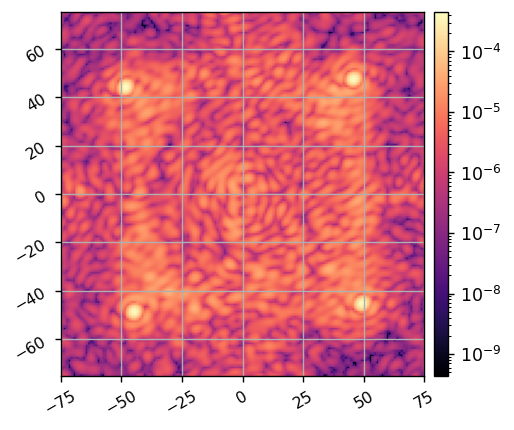

In [97]:
I.Nframes = 10
I.npsf = 150
I.x_shift = xshift
I.y_shift = yshift-1

I.subtract_dark = True
I.return_ni = True

waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=1, grid=True)

Set the ZWO exposure time to 5.00e-03s
4.609522947673535e-06


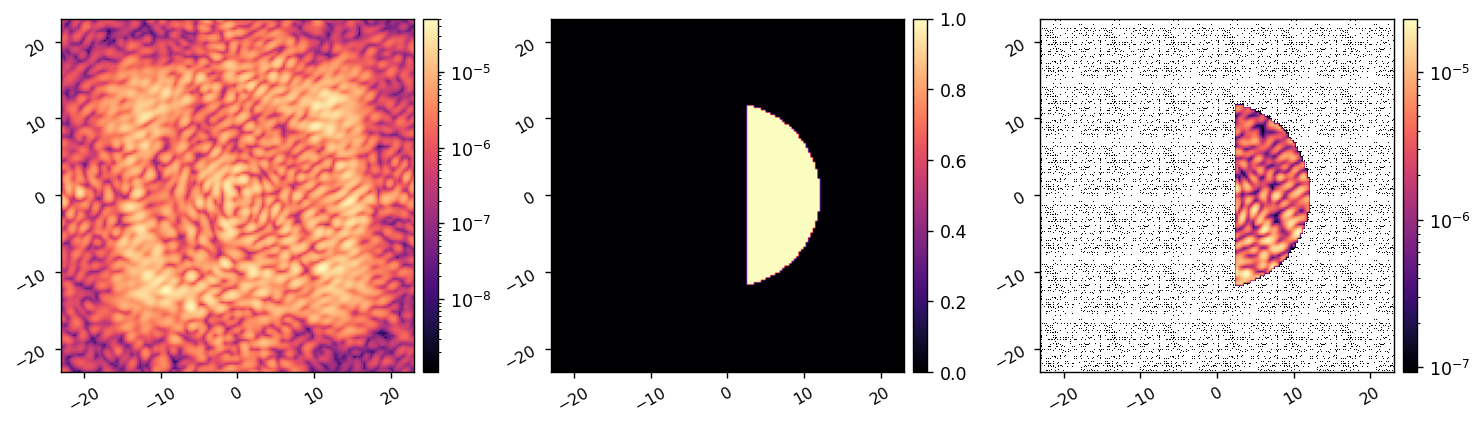

Saved data to:  data/20241025_ref_coro_im.fits


In [98]:
iwa = 2.5
owa = 12
rotation = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, iwa, owa, edge=iwa, rotation=rotation)

I.zero_dm()
I.NSCICAM = 10
I.subtract_dark = True
I.return_ni = True
I.set_zwo_exp_time(0.005, client0)

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamD)
lina.utils.save_fits(f'data/{today}_ref_coro_im.fits', ref_coro_im)

Set the ZWO exposure time to 1.00e-02s
5.830139874792088e-06


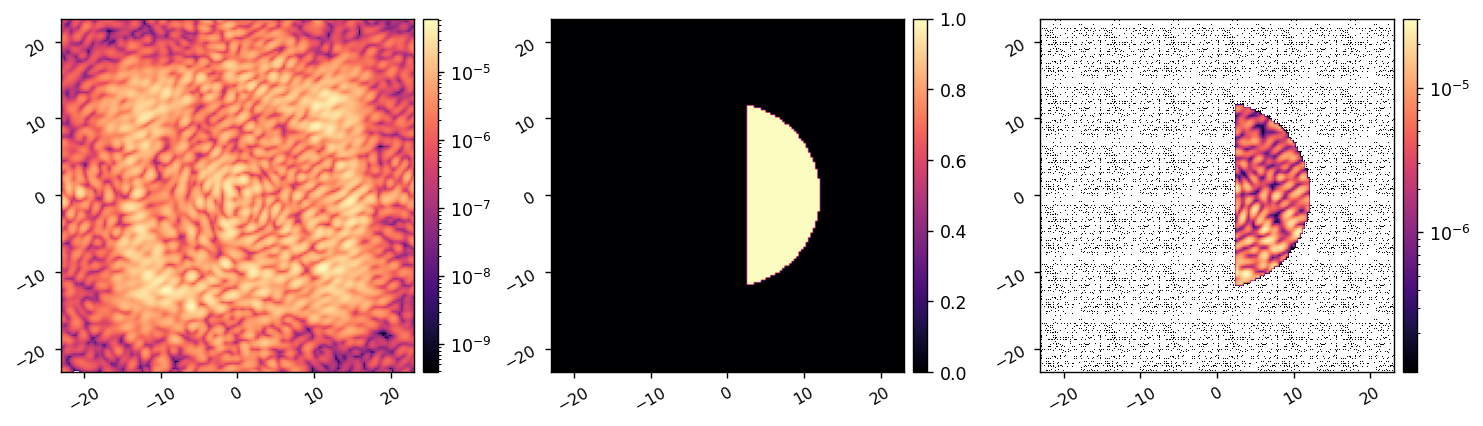

Saved data to:  data/20241025_ref_coro_im.fits


In [174]:
iwa = 2.5
owa = 12
rotation = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, iwa, owa, edge=iwa, rotation=rotation)

I.zero_dm()
I.NSCICAM = 10
I.subtract_dark = True
I.return_ni = True
I.set_zwo_exp_time(0.01, client0)

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamD)
lina.utils.save_fits(f'data/{today}_ref_coro_im.fits', ref_coro_im)

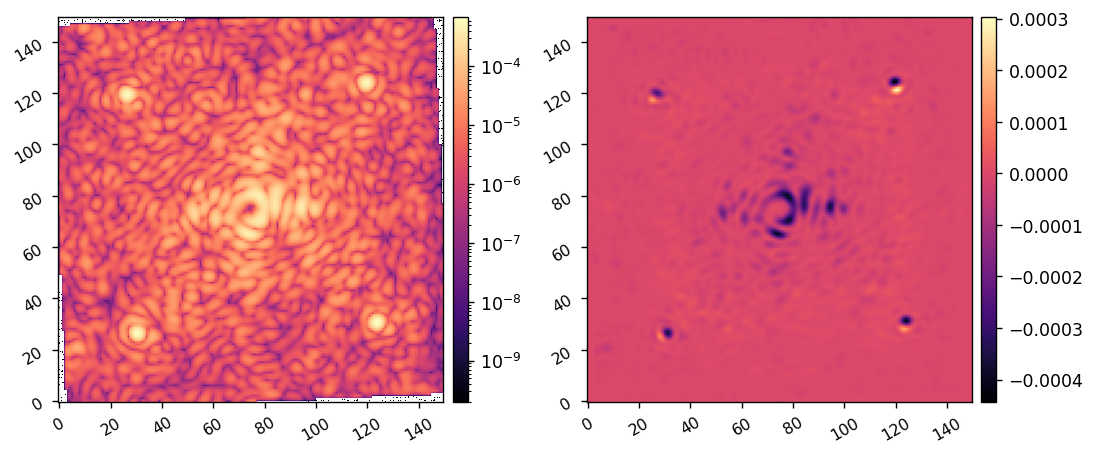

In [177]:
reload(rmad)
M = rmad.MODEL()
M.WFE = WFE

M.flip_dm = 1
M.flip_lyot_ud = 1
M.det_rotation = -2.5

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

M.set_dm(10e-9 * waffle_command)
M.setattr('use_vortex', True)
m_waffle_im = M.snap()

imshow2(m_waffle_im, waffle_im-m_waffle_im, lognorm1=True)
# fpwf = M.forward(np.zeros(M.Nacts), use_vortex=True, plot=True)


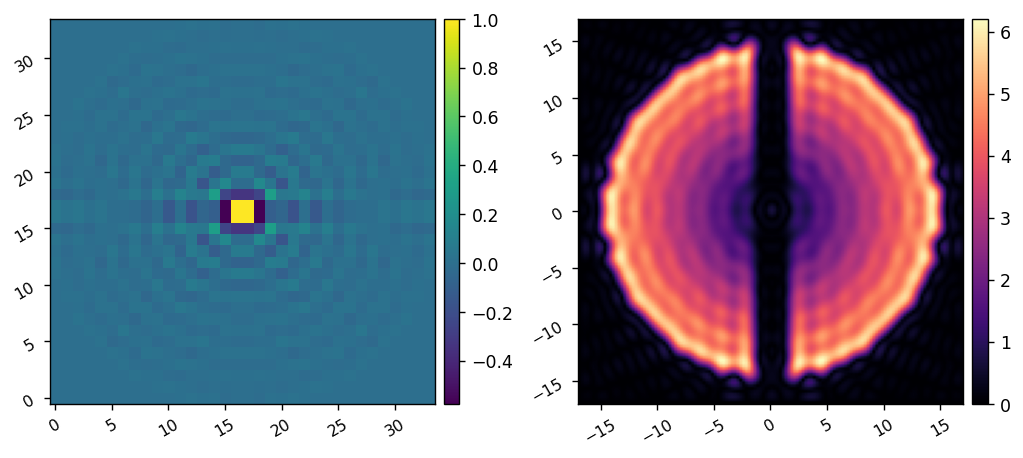

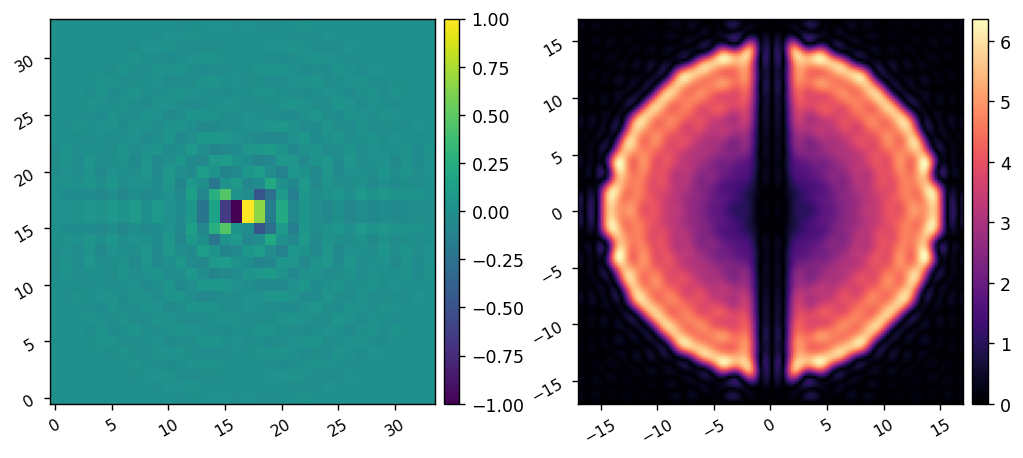

In [178]:
fourier_probes = lina.utils.create_fourier_probes(xp.array(I.dm_mask), I.npsf, I.psf_pixelscale_lamD, 2, 14, 
                                                  rotation=0, 
                                                  fourier_sampling=0.75, 
                                                    nprobes=2,
                                                    plot=True,
                                                    use_weighting=True
                                                    )

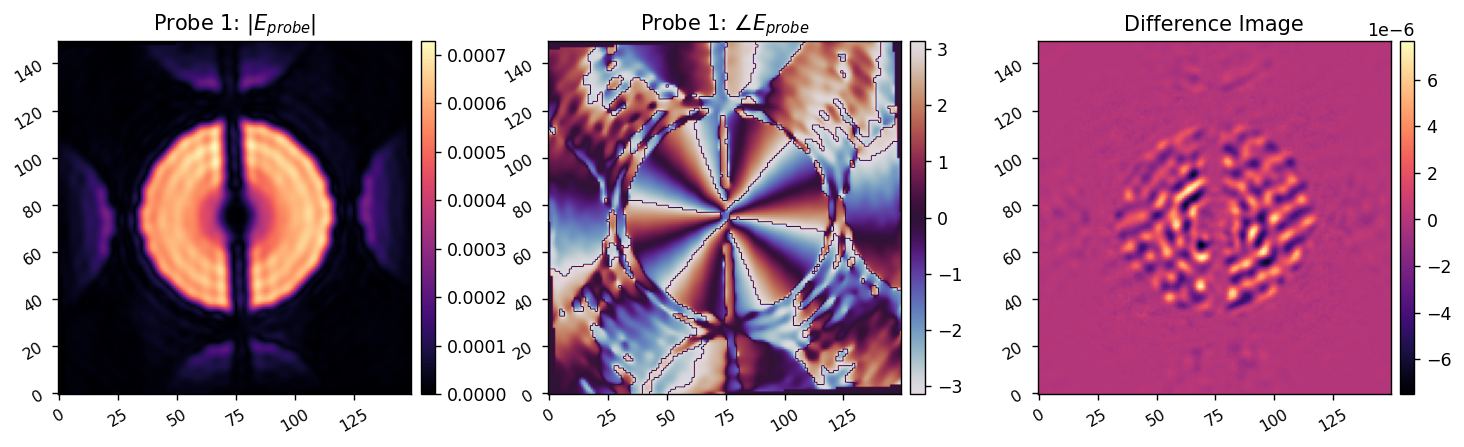

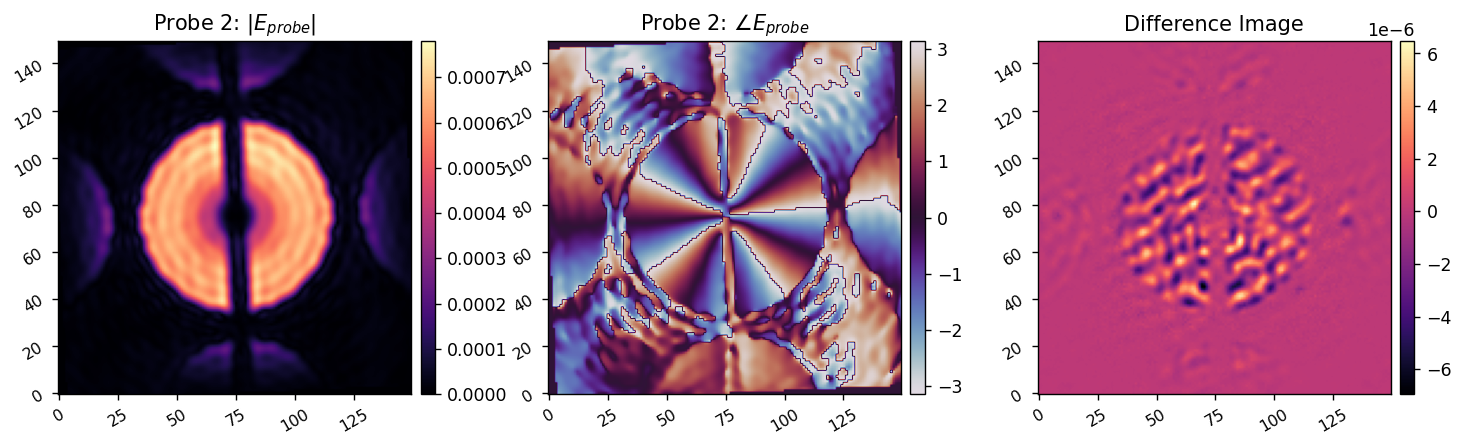

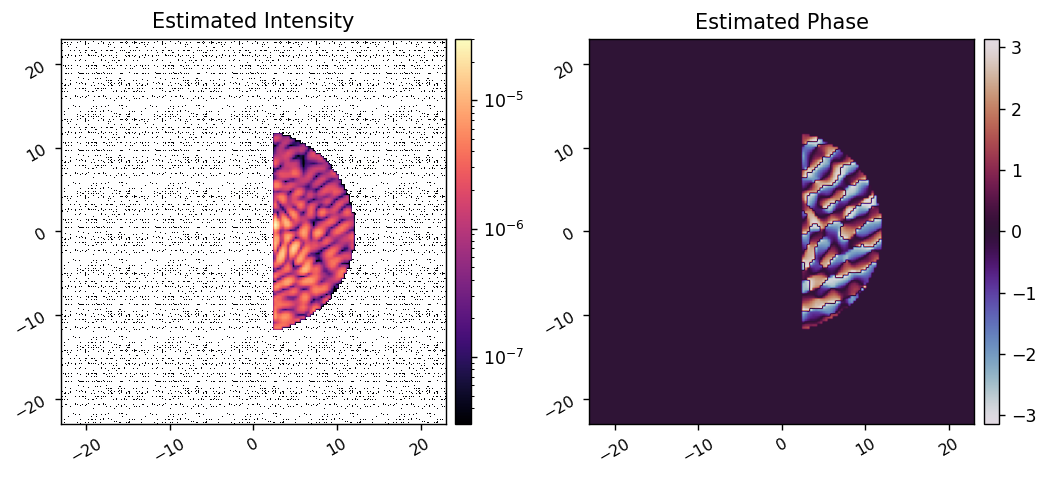

In [179]:
import lina.adefc as adefc
reload(adefc)

acts = xp.zeros(M.Nacts)

I.set_dm(rmad.acts_to_command(acts, M.dm_mask))
E_pwp = adefc.run_pwp(I, M, I.get_dm()[M.dm_mask], control_mask, fourier_probes, 5e-9, plot=True, reg_cond=1e-2)
I_pwp = xp.abs(E_pwp)**2
P_pwp = xp.angle(E_pwp)

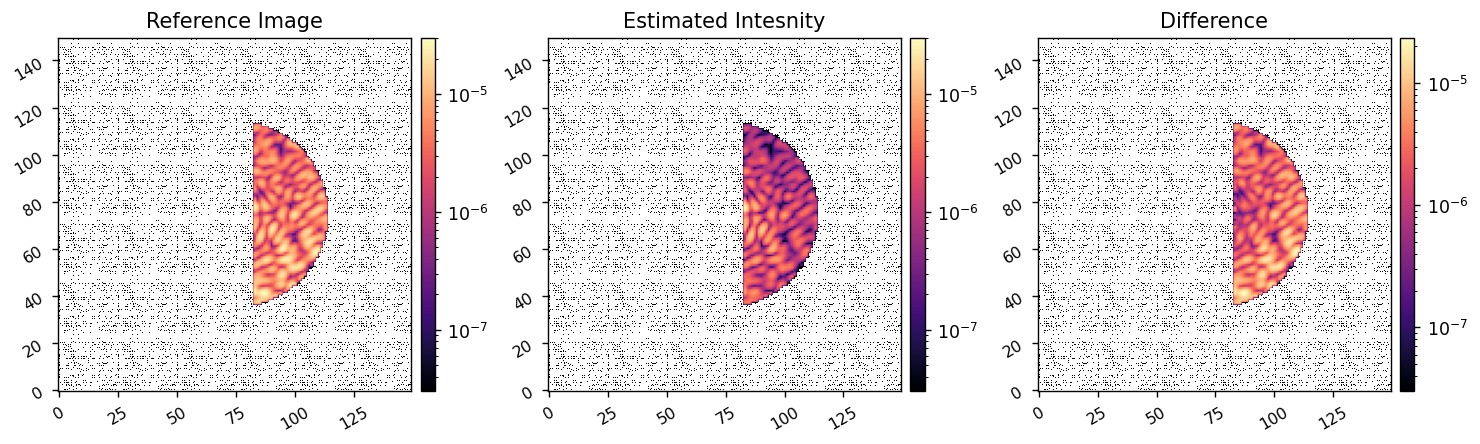

In [180]:
I_diff = ref_coro_im*control_mask - I_pwp
vmin = xp.max(ref_coro_im*control_mask)/1e3
imshow3(ref_coro_im*control_mask, I_pwp, xp.abs(I_diff), 
        'Reference Image', 'Estimated Intesnity', 'Difference',
        lognorm1=True, lognorm2=True, vmin1=vmin, vmin2=vmin, 
        lognorm3=True, vmin3=vmin,
        )

In [189]:
I.zero_dm()
all_ims = []
all_efs = []
all_commands = []


Running estimation algorithm ...


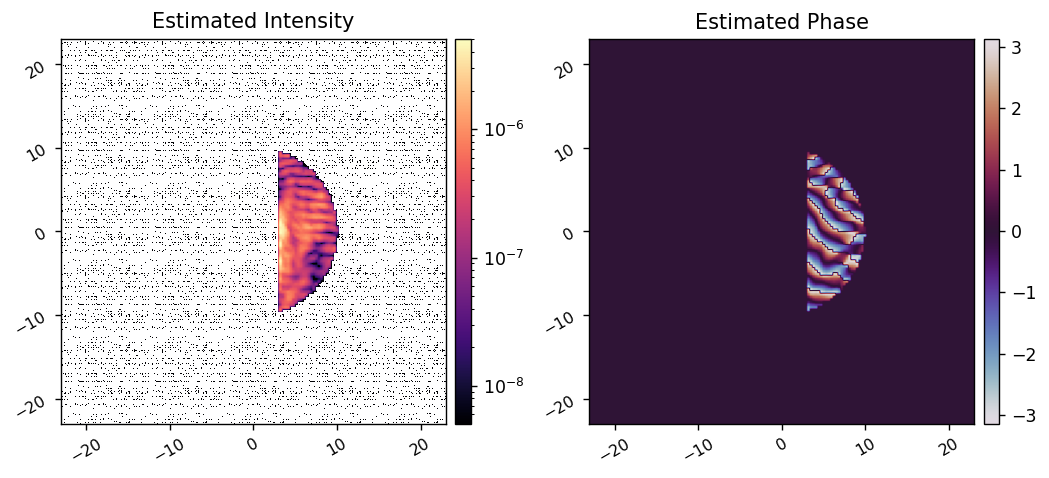

Computing EFC command with L-BFGS


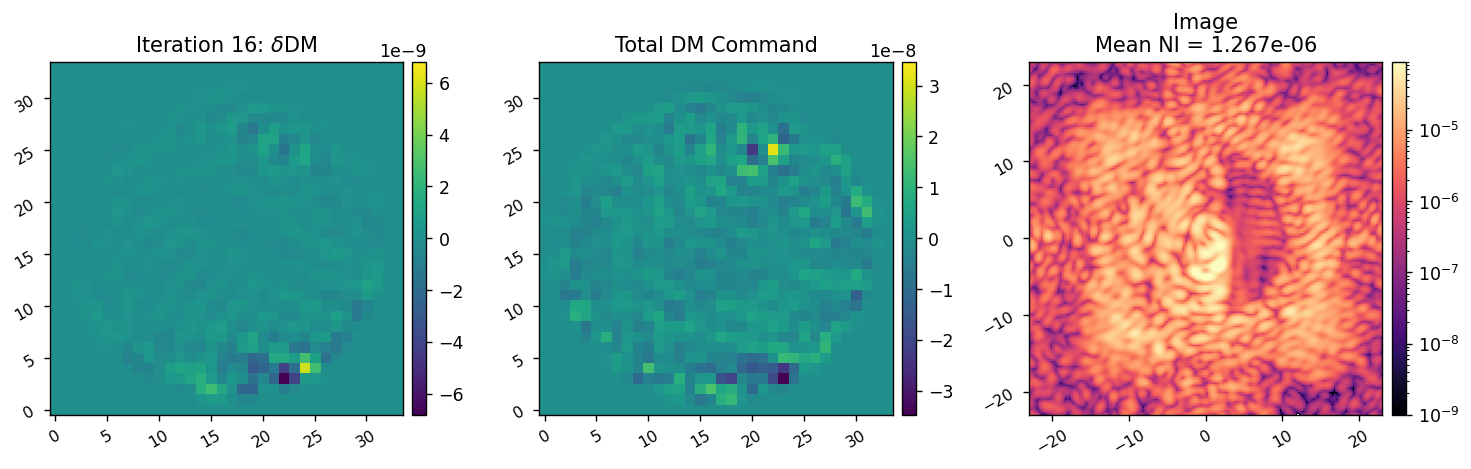

Running estimation algorithm ...


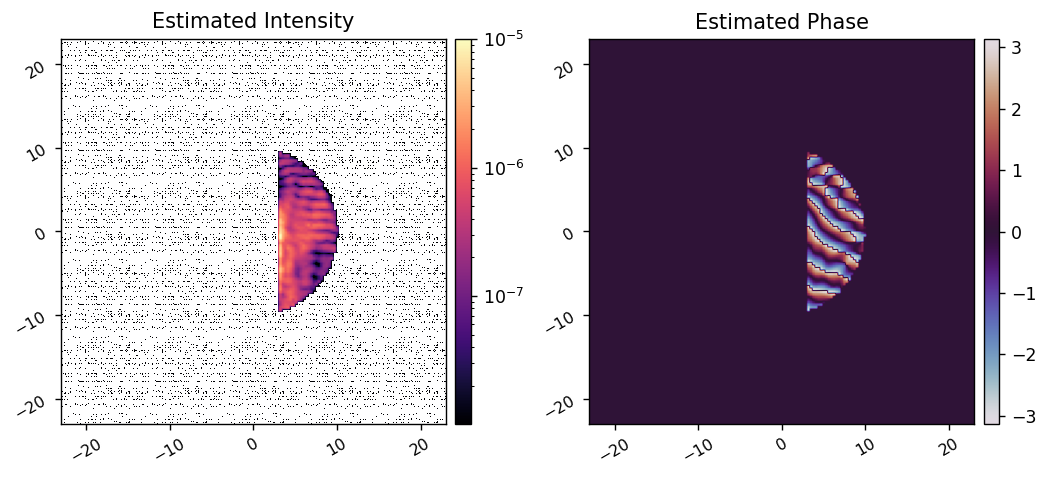

Computing EFC command with L-BFGS


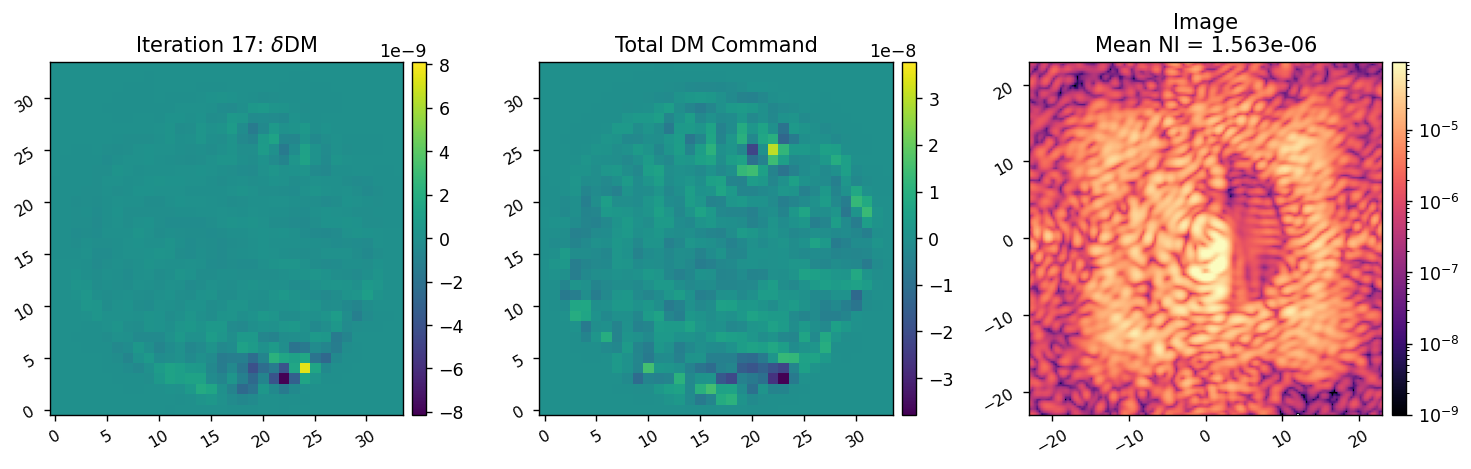

Running estimation algorithm ...


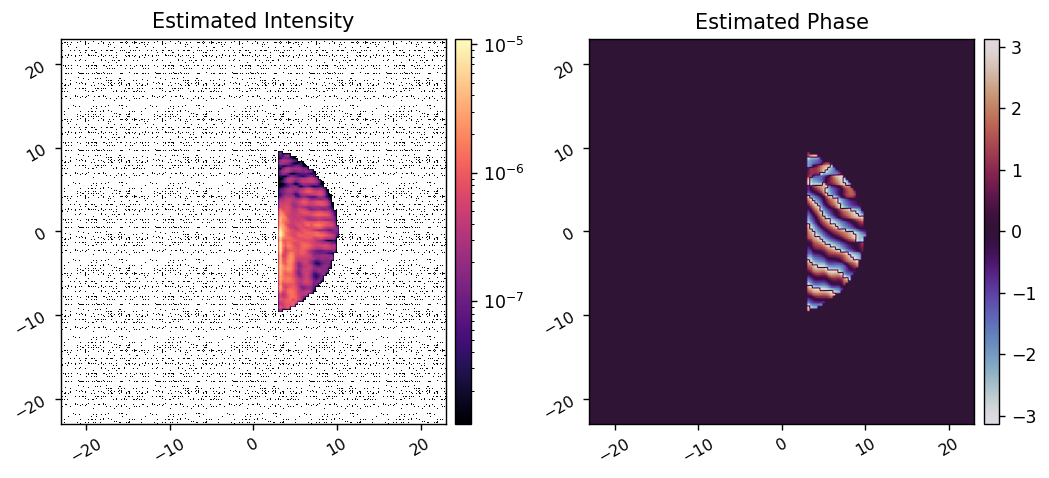

Computing EFC command with L-BFGS


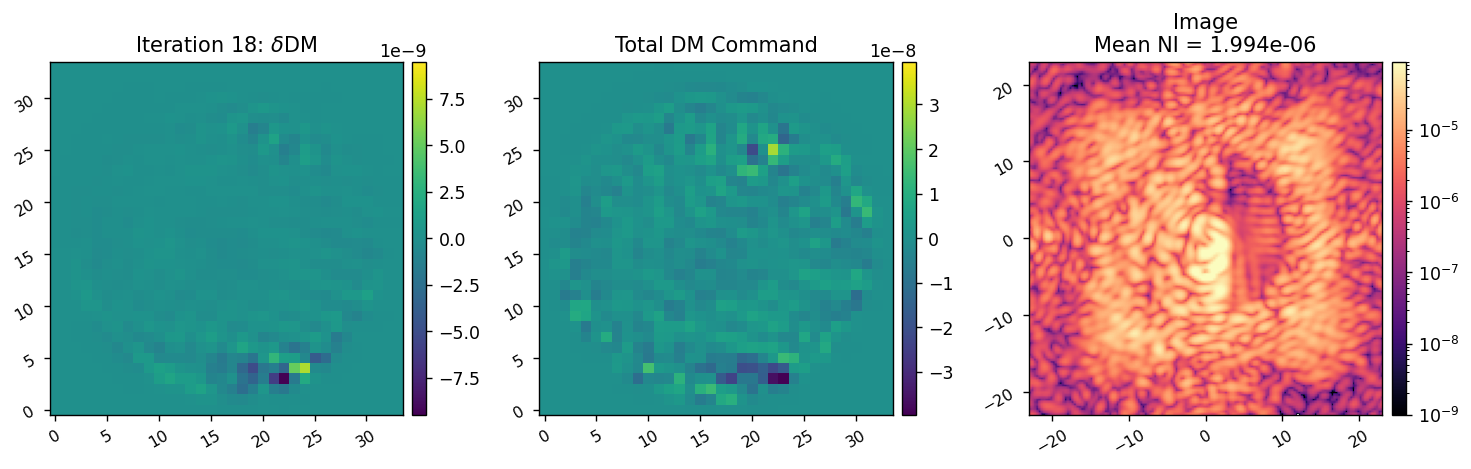

In [188]:
reload(rmad)
reload(adefc)

iwa = 3
owa = 10
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, iwa, owa, edge=iwa, rotation=rotation)

r_cond = 1e-1
# r_cond = 1e-2
# r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
# r_cond = 1e-6

bfgs_tol = 1e-2
# bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':False,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

est_fun = adefc.run_pwp
est_params = {
    'control_mask':control_mask, 
    'probes':fourier_probes,
    # 'probe_amp':5e-9,
    # 'probe_amp':4e-9,
    # 'probe_amp':3e-9,
    'probe_amp':2e-9,
    'reg_cond':1e-2,
    'plot':False,
    'plot_est':True, 
}

I.NSCICAM = 50

all_ims, all_efs, all_commands = adefc.run(I, M, rmad.val_and_grad, control_mask, 
                                           est_fun, est_params, 
                                           Nitr=3, 
                                           reg_cond=r_cond,
                                           bfgs_tol=bfgs_tol,
                                           bfgs_opts=bfgs_opts,
                                           gain=1,
                                           all_ims=all_ims,
                                           all_efs=all_efs,
                                           all_commands=all_commands,
                                           )

Running estimation algorithm ...


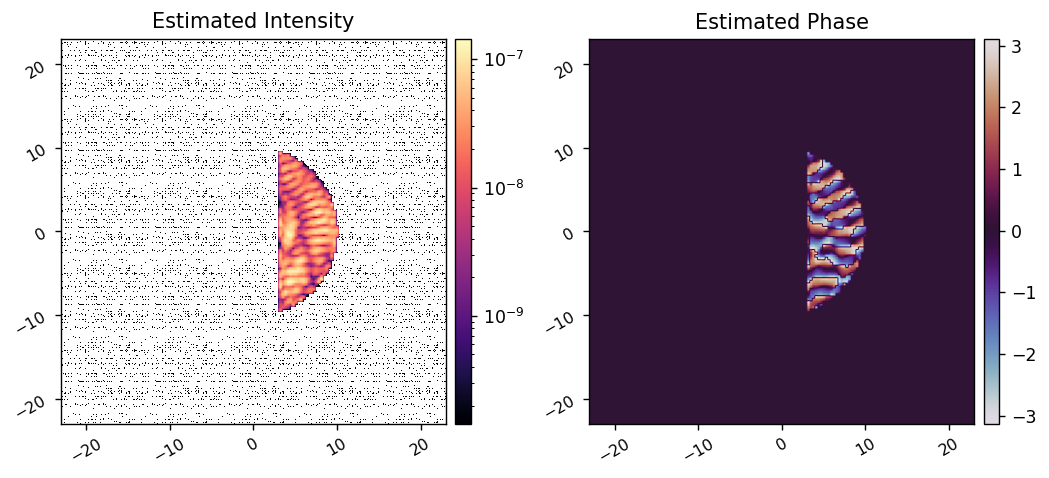

Computing EFC command with L-BFGS


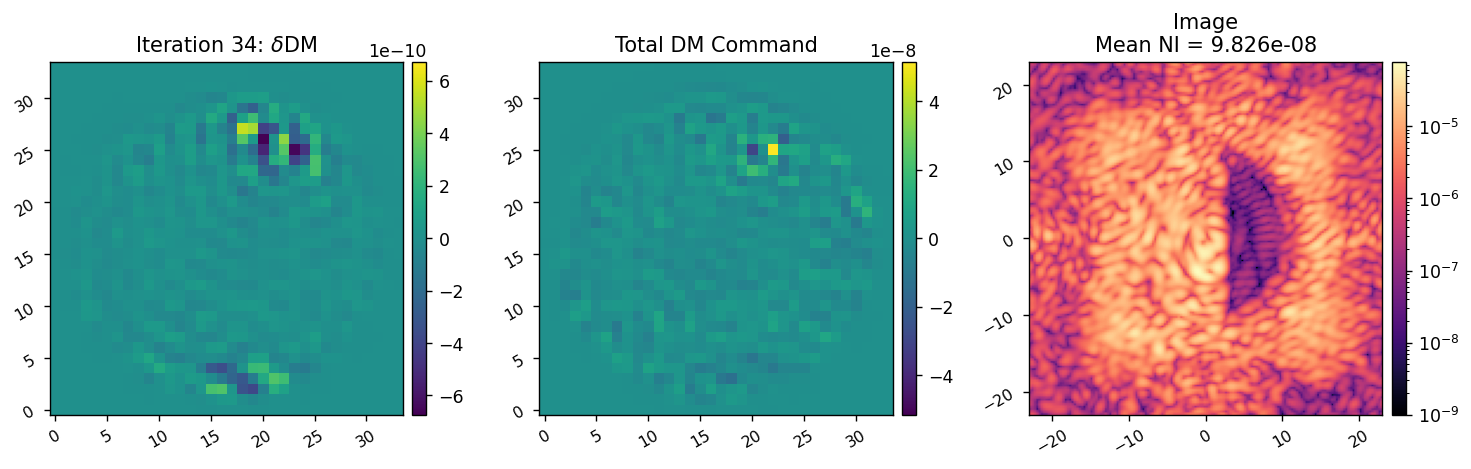

Running estimation algorithm ...


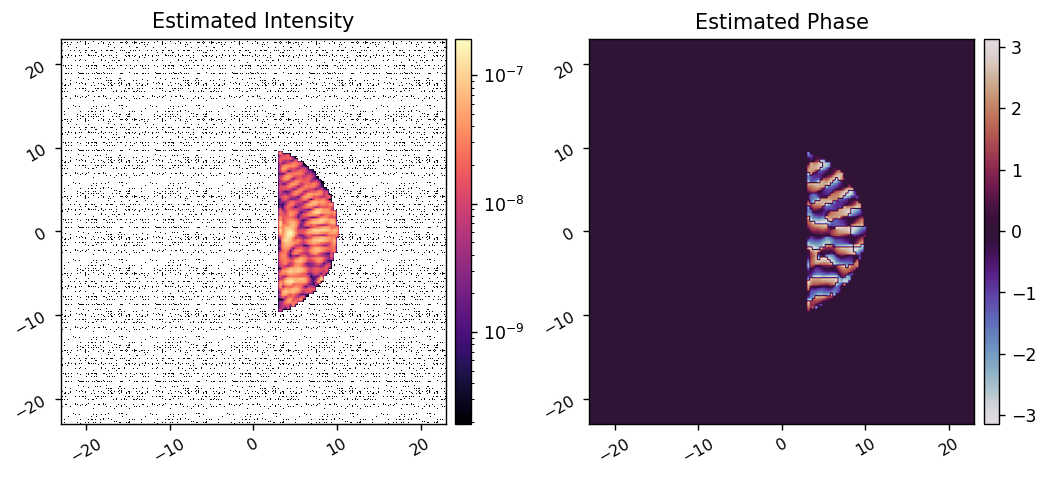

Computing EFC command with L-BFGS


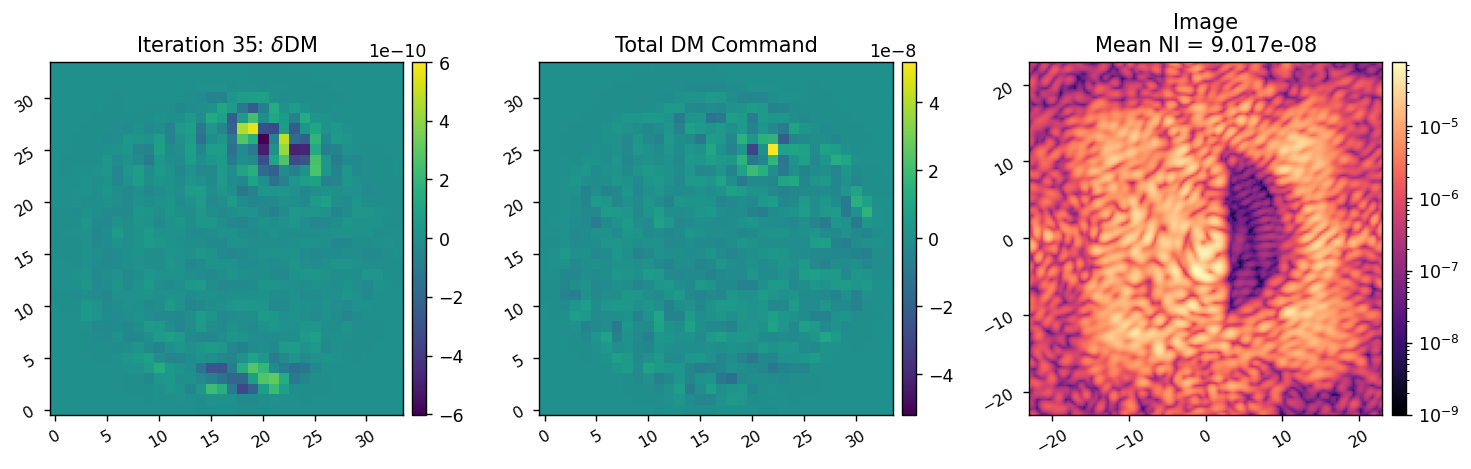

Running estimation algorithm ...


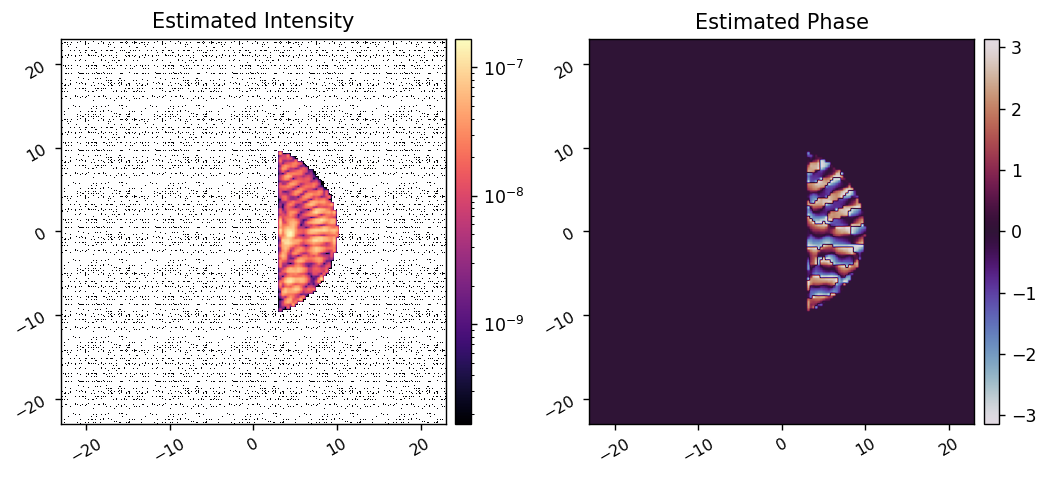

Computing EFC command with L-BFGS


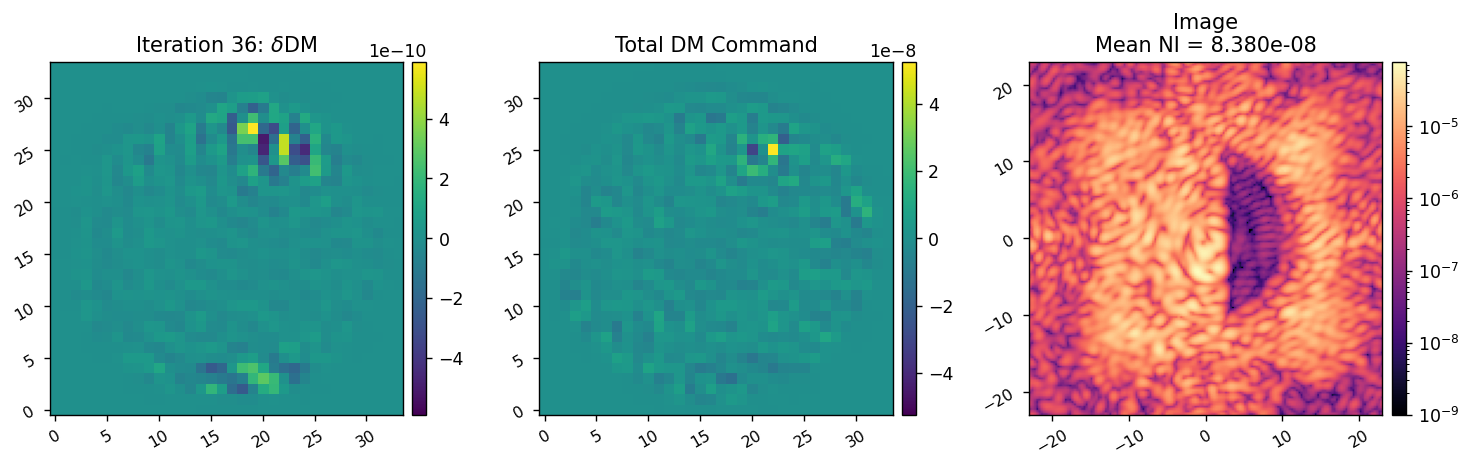

In [128]:
reload(rmad)
reload(adefc)

iwa = 3
owa = 10
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, iwa, owa, edge=iwa, rotation=rotation)

r_cond = 1e-1
# r_cond = 1e-2
# r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
# r_cond = 1e-6

bfg_tol = 0.02
# bfgs_tol = 1e-2
# bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':False,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

est_fun = adefc.run_pwp
est_params = {
    'control_mask':control_mask, 
    'probes':fourier_probes,
    # 'probe_amp':5e-9,
    # 'probe_amp':4e-9,
    # 'probe_amp':3e-9,
    'probe_amp':2e-9,
    'plot':False,
    'plot_est':True, 
}

I.NSCICAM = 50

all_ims, all_efs, all_commands = adefc.run(I, M, rmad.val_and_grad, control_mask, 
                                           est_fun, est_params, 
                                           Nitr=3, 
                                           reg_cond=r_cond,
                                           bfgs_tol=bfgs_tol,
                                           bfgs_opts=bfgs_opts,
                                           gain=1,
                                           all_ims=all_ims,
                                           all_efs=all_efs,
                                           all_commands=all_commands,
                                           )

In [166]:
lina.utils.save_fits(f'data/{today}_adefc_ims.fits', xp.array(all_ims))
lina.utils.save_fits(f'data/{today}_adefc_efs_r.fits', xp.array(all_efs).real)
lina.utils.save_fits(f'data/{today}_adefc_efs_i.fits', xp.array(all_efs).imag)
lina.utils.save_fits(f'data/{today}_adefc_commands.fits', xp.array(all_commands))

Saved data to:  data/20241025_adefc_ims.fits
Saved data to:  data/20241025_adefc_efs_r.fits
Saved data to:  data/20241025_adefc_efs_i.fits
Saved data to:  data/20241025_adefc_commands.fits


In [143]:
I.texp

0.005

In [144]:
I.set_zwo_exp_time(0.05, client0, delay=1)
I.set_zwo_gain(120, client0)

Set the ZWO exposure time to 5.00e-02s
Set the ZWO gain setting to 120.0


In [145]:
reload(scoobi)
scoobi.move_block_in(client0)

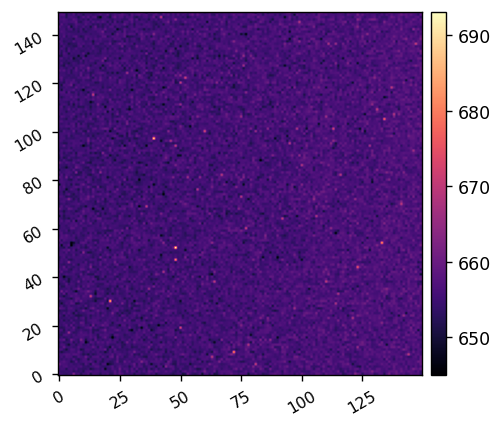

In [146]:
I.NSCICAM = 100
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

In [147]:
reload(scoobi)
scoobi.move_block_out(client0)

In [158]:
I.texp, I.gain, I.atten, I.ref_psf_params

(0.05,
 120,
 8,
 {'ref_psf': array([[640.96, 640.02, 639.  , ..., 639.7 , 638.84, 641.74],
         [640.08, 640.92, 642.04, ..., 638.68, 639.96, 640.24],
         [639.22, 640.68, 640.38, ..., 640.5 , 639.22, 640.72],
         ...,
         [641.26, 640.56, 642.2 , ..., 639.56, 639.74, 639.12],
         [640.94, 640.78, 641.8 , ..., 640.66, 639.48, 640.64],
         [639.48, 640.58, 640.3 , ..., 642.3 , 638.96, 639.6 ]]),
  'Imax': array(54336.78),
  'texp': 0.00012,
  'atten': 30,
  'gain': 120})

In [157]:
I.set_fib_atten(8, client)

Set the fiber attenuation to 8.0


6.969592597326543e-08


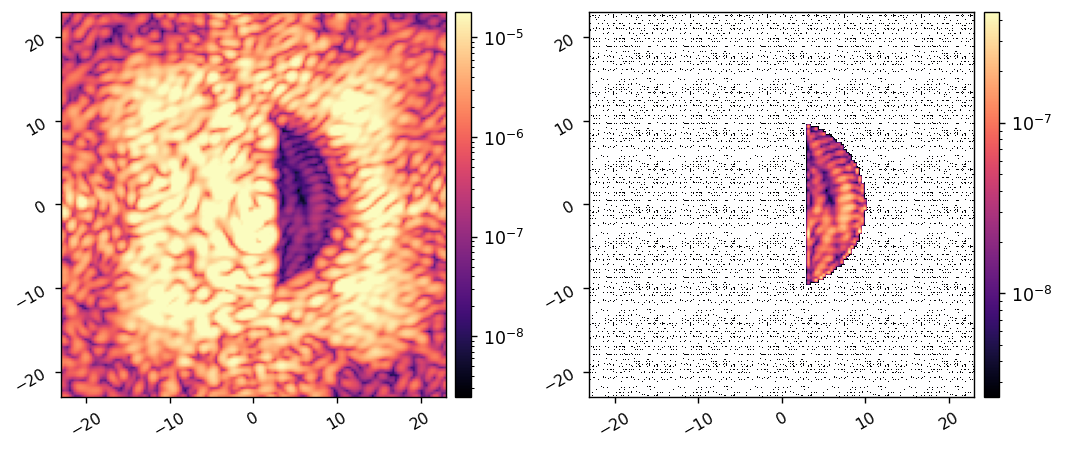

In [159]:
I.NSCICAM = 70
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[control_mask]))
imshow2(coro_im, control_mask * coro_im,
        lognorm=True, pxscl=I.psf_pixelscale_lamD)

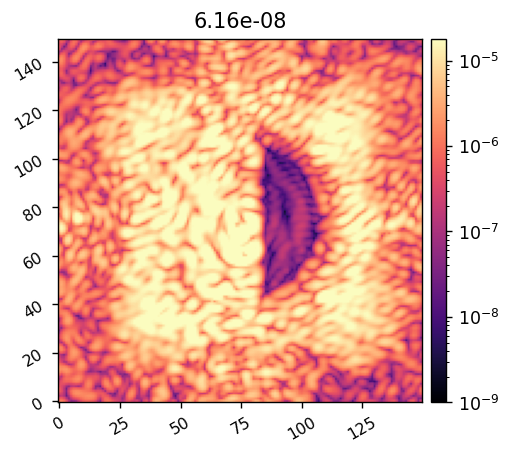

In [199]:
ims = utils.load_fits(f'data/{today}_adefc_ims.fits')
i = -1
mean_ni = xp.mean(ims[i][control_mask])
imshow1(ims[i], f'{mean_ni:.2e}', lognorm=True, vmin=1e-9)